# 05__divergent
# analyzing divergent sequences: conservation and directionality preferences

in this notebook, i analyze two properties of divergent sequences: (1) their conservation (using phylop 100-way vertebrate alignments) and (2) their "directionality preference". by that i mean whether or not they are more likely to activate transcription in the sense direction vs. the antisense direction.

------

figures in this notebook:
- **Fig S10**: bar plot showing sequences with directionality preferences within biotypes

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from scipy import stats
from scipy import signal
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## functions

In [3]:
def padj_in_one(row):
    if not pd.isnull(row["hepg2_sig"]):
        if not pd.isnull(row["hepg2_sig"]):
            return True
    elif not pd.isnull(row["hela_sig"]):
        if not pd.isnull(row["hela_sig"]):
            return True
    elif not pd.isnull(row["k562_sig"]):
        if not pd.isnull(row["k562_sig"]):
            return True
    else:
        return False

In [4]:
def sig_in_one(row):
    if row["hepg2_sig"] == "sig" or row["k562_sig"] == "sig" or row["hela_sig"] == "sig":
        return True
    else:
        return False

## variables

In [5]:
biotypes = ["div_lnc", "div_pc", "enhancerMid", "intergenic", "protein_coding"]

In [6]:
bw_f = "../../misc/01__phylop/hg19.100way.phyloP100way.bw"

In [7]:
index_dir = "../../data/00__index"
index_f = "%s/tss_oligo_pool.index.txt" % index_dir

In [8]:
hepg2_activ_f = "../../data/02__activs/POOL1__pMPRA1__HepG2__activities_per_barcode.txt"
hela_activ_f = "../../data/02__activs/POOL1__pMPRA1__HeLa__activities_per_barcode.txt"
k562_activ_f = "../../data/02__activs/POOL1__pMPRA1__K562__activities_per_barcode.txt"

In [9]:
annot_f = "../../misc/00__tss_properties/correspondance_seqID_PromType_unique.txt"

# conservation

## 1. find phyloP scores for TSS +/- 1000

In [10]:
in_path = "../../data/00__index/0__all_tss"
out_path = "tmp"
!mkdir -p $out_path
up = 1000
down = 1000

for b in biotypes:
    bed_f = "%s/TSS.start.1perGencGene.500bp.%s.bed" % (in_path, b)
    phylop_f = "%s/TSS.start.1perGencGene.500bp.%s.%sup%sdown.phylop.txt" % (out_path, b, up, down)
    !bwtool matrix $up:$down $bed_f $bw_f $phylop_f

## 2. read files and find column avg

In [11]:
data = pd.DataFrame()

up = 1000
down = 1000

for b in biotypes:
    phylop_f = "%s/TSS.start.1perGencGene.500bp.%s.%sup%sdown.phylop.txt" % (out_path, b, up, down)
    tmp = pd.read_table(phylop_f, sep="\t", header=None)
    avg = list(tmp.mean(axis=0))
    ste = list(tmp.std(axis=0)/(np.sqrt(len(tmp))))
    n = len(tmp)
    tmp = pd.DataFrame(data={"mean": avg, "ste": ste})
    tmp["type"] = b
    tmp["num"] = n
    tmp = tmp.reset_index()
    tmp.columns = ["idx", "mean", "ste", "type", "num"]
    tmp["ntd"] = list(range(-1*up, down))
    data = data.append(tmp)

data["y1"] = data["mean"] - data["ste"]
data["y2"] = data["mean"] + data["ste"]
data.sample(5)

idx      mean       ste            type    num  ntd        y1        y2
1492  1492  0.397260  0.045110          div_pc   1540  492  0.352150  0.442370
1088  1088  0.477011  0.012893  protein_coding  17300   88  0.464118  0.489904
1518  1518  0.070694  0.015464      intergenic   4562  518  0.055230  0.086158
677    677  0.083841  0.005935     enhancerMid  29871 -323  0.077906  0.089777
603    603  0.074703  0.016067      intergenic   4562 -397  0.058637  0.090770

## 3. plot

In [12]:
palette = {"intergenic": sns.color_palette()[2], "enhancerMid": sns.color_palette()[1],
           "div_pc": sns.color_palette()[0], "protein_coding": sns.color_palette()[5], 
           "div_lnc": sns.color_palette()[3]}

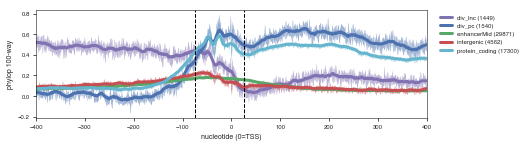

In [13]:
fig = plt.figure(figsize=(7,2))

lower = -400
upper = 400

for b in biotypes:
    df = data[(data["type"] == b) & (data["ntd"] >= lower) & (data["ntd"] < upper)]
    x = signal.savgol_filter(df["mean"], 15, 1)
    plt.fill_between(df["ntd"], df["y1"], df["y2"], color=palette[b], alpha=0.5)
    plt.plot(df["ntd"], x, color=palette[b], linewidth=3, label="%s (%s)" % (b, df["num"].iloc[0]))
plt.xlim((lower, upper))
plt.axvline(x=-75, color="black", linestyle="dashed", linewidth=1)
plt.axvline(x=25, color="black", linestyle="dashed", linewidth=1)
plt.legend(ncol=1, loc=1, bbox_to_anchor=(1.25, 1))
plt.xlabel("nucleotide (0=TSS)")
plt.ylabel("phylop 100-way")

In [14]:
order = ["enhancerMid", "intergenic", "div_lnc", "protein_coding", "div_pc"]

In [15]:
data["log_mean"] = np.log(data["mean"]+1)
data.head()

idx      mean       ste     type   num   ntd        y1        y2  log_mean
0    0  0.329765  0.041591  div_lnc  1449 -1000  0.288174  0.371356  0.285003
1    1  0.335652  0.042628  div_lnc  1449  -999  0.293024  0.378280  0.289420
2    2  0.381504  0.042440  div_lnc  1449  -998  0.339065  0.423944  0.323173
3    3  0.349979  0.042267  div_lnc  1449  -997  0.307712  0.392247  0.300089
4    4  0.357640  0.041562  div_lnc  1449  -996  0.316078  0.399201  0.305748

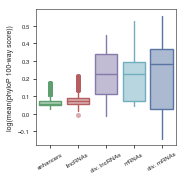

In [16]:
plt.figure(figsize=(2.5, 2.5))
ax = sns.boxplot(data=data, x="type", y="log_mean", order=order, palette=palette,
                 flierprops=dict(marker='o', markersize=5))
ax.set_xticklabels(["enhancers", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
mimic_r_boxplot(ax)
ax.set_ylabel("log(mean(phyloP 100-way score))")
ax.set_xlabel("")

# directionality preference

## 1. import data

In [17]:
index = pd.read_table(index_f, sep="\t")

In [18]:
index_elem = index[["element", "oligo_type", "unique_id", "dupe_info", "SNP", "seq_name"]]
index_elem = index_elem.drop_duplicates()

In [19]:
hepg2_activ = pd.read_table(hepg2_activ_f, sep="\t")
hela_activ = pd.read_table(hela_activ_f, sep="\t")
k562_activ = pd.read_table(k562_activ_f, sep="\t")

In [20]:
hepg2_reps = [x for x in hepg2_activ.columns if "rna" in x]
hela_reps = [x for x in hela_activ.columns if "rna" in x]
k562_reps = [x for x in k562_activ.columns if "rna" in x]

In [21]:
annot = pd.read_table(annot_f, sep="\t")
annot.head()

seqID PromType2
0  WILDTYPE__Antisense.noflip.NA__chr1:100435456....   div_lnc
1  WILDTYPE__Lincrna.flip.sense__chr1:100731637.....   div_lnc
2  FLIPPED__Lincrna.flip.antisense__chr1:10073163...   div_lnc
3  FLIPPED__mrna.flip.antisense__chr1:100731714.....    div_pc
4  WILDTYPE__mrna.flip.sense__chr1:100731714..100...    div_pc

## 2. find mean activ per barcode and merge info

In [22]:
hepg2_cols = ["barcode"] + ["hepg2_%s" % x for x in hepg2_reps]
k562_cols = ["barcode"] + ["k562_%s" % x for x in k562_reps]
hela_cols = ["barcode"] + ["hela_%s" % x for x in hela_reps]
hela_cols

['barcode', 'hela_rna_1', 'hela_rna_2', 'hela_rna_3', 'hela_rna_4']

In [23]:
hepg2_activ.columns = hepg2_cols
k562_activ.columns = k562_cols
hela_activ.columns = hela_cols
hela_activ.head()

barcode  hela_rna_1  hela_rna_2  hela_rna_3  hela_rna_4
0  AAAACAAAGTC   -0.839231         NaN   -4.842099         NaN
1  AAAACAAAGTT         NaN         NaN         NaN         NaN
2  AAAACAAATGT   -2.198951   -0.945005   -2.426499         NaN
3  AAAACAACGTC         NaN         NaN         NaN    0.764346
4  AAAACAACGTG         NaN         NaN         NaN    3.523603

In [24]:
data = index.merge(hepg2_activ[hepg2_cols], on="barcode").merge(hela_activ[hela_cols], on="barcode").merge(k562_activ[k562_cols], on="barcode")
data.sample(5)

full_oligo  \
555     ACTGGCCGCTTCACTGAGCCAATCCCAGTCTCGCGACTCCTGCTTG...   
20681   ACTGGCCGCTTCACTGCTTTGGGGCGTCGGCTCACGTGCGGCCGGC...   
103377  ACTGGCCGCTTCACTGTCCCAGGGTGTGATGCATGCGTAGTATCAG...   
38383   ACTGGCCGCTTCACTGTTAACTCCGGGCCCCCTCGAGGGCCTCACC...   
31850   ACTGGCCGCTTCACTGTATCACAGGGGCGCGCCTCAGCTGACGTCA...   

                     oligo_type       oligo_id dupe_info  \
555        WILDTYPE_BUT_HAS_SNP    11.1.0.0.16      none   
20681   WILDTYPE_SNP_PLUS_HAPLO   531.1.2.1.12      none   
103377       WILDTYPE_SNP_INDIV  2246.1.1.0.12      none   
38383                  WILDTYPE   982.1.0.0.12      none   
31850      WILDTYPE_BUT_HAS_SNP    810.1.0.0.2      none   

                                                seq_name  \
555     Antisense.noflip.NA__chr1:119683314..119683428,+   
20681      Lincrna.noflip.NA__chr22:45559539..45559653,-   
103377   Enhancer.flip.sense__chr18:21417670..21417784,-   
38383       mrna.noflip.NA__chr11:124670529..124670643,-   
31850       Lincrna.noflip.NA__chr7:65958508..65958622,-   

                                                tile_name    chr  locus_start  \
555     Antisense.noflip.NA__chr1:119683314..119683428...   chr1  119683314.0   
20681   Lincrna.noflip.NA__chr22:45559539..45559653,-,...  chr22   45559539.0   
103377  Enhancer.flip.sense__chr18:21417670..21417784,...  chr18   21417670.0   
38383   mrna.noflip.NA__chr11:124670529..124670643,-,9...  chr11  124670529.0   
31850   Lincrna.noflip.NA__chr7:65958508..65958622,-,8...   chr7   65958508.0   

          locus_end strand    ...      hepg2_rna_13  hepg2_rna_14  hela_rna_1  \
555     119683428.0      +    ...          0.443712      0.708184    1.608763   
20681    45559653.0      -    ...               NaN           NaN         NaN   
103377   21417784.0      -    ...         -0.555727      0.080551   -4.899333   
38383   124670643.0      -    ...         -0.369510     -0.552770         NaN   
31850    65958622.0      -    ...          1.629043      1.322133    3.240992   

        hela_rna_2  hela_rna_3  hela_rna_4  k562_rna_1  k562_rna_2 k562_rna_3  \
555            NaN    1.990065         NaN         NaN    0.216513   2.618827   
20681          NaN         NaN         NaN         NaN         NaN        NaN   
103377   -1.466480         NaN         NaN   -2.502281   -1.508452  -1.998198   
38383          NaN         NaN         NaN   -3.735473         NaN        NaN   
31850     1.665025    1.148214   -1.445068    1.621101    2.647106   3.401449   

       k562_rna_4  
555      0.166163  
20681         NaN  
103377  -1.844742  
38383         NaN  
31850    2.424848  

[5 rows x 42 columns]

## 3. make map of flipped to not flipped

In [25]:
index_elem["cage_id"] = index_elem.apply(get_cage_id, axis=1)
index_elem.sample(5)

element  \
100647  CCGCGTTTGCAAGAAACCGAAACCCAGGCTCCGCCCCTTCGGCGCG...   
21341   ACCGCGGCGCCGGCGCCGGCCCGCCCCCACGCCTGACTACGCCCCC...   
30286   CATTGGTGAGTGAGGTTCCCCGCCCAGAAAAGGCGGGGGCGCTTTC...   
119173  TAGGCTTGTATAGGGGCACACGATAGGCCCCGAACCGCACACGGCC...   
9738    GCTGGGGTAGGAAATTGATGATGTGATACCGGAAGTGATCTGGCAG...   

                  oligo_type  \
100647  WILDTYPE_BUT_HAS_SNP   
21341               WILDTYPE   
30286     WILDTYPE_SNP_INDIV   
119173                RANDOM   
9738                WILDTYPE   

                                                unique_id dupe_info  \
100647  WILDTYPE_BUT_HAS_SNP__Enhancer.flip.sense__chr...      none   
21341   WILDTYPE__Antisense.flip.sense__chr3:153839086...      none   
30286   WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr7:...      none   
119173            RANDOM__random_sequence__randSeq__763.1       NaN   
9738    WILDTYPE__Lincrna.noflip.NA__chr12:76653539..7...      none   

               SNP                                           seq_name  \
100647        none   Enhancer.flip.sense__chr5:131832624..131832738,-   
21341         none  Antisense.flip.sense__chr3:153839086..153839200,-   
30286   rs13238374   Antisense.noflip.NA__chr7:121944881..121944995,+   
119173        none                                    random_sequence   
9738          none      Lincrna.noflip.NA__chr12:76653539..76653653,+   

                          cage_id  
100647  chr5:131832624..131832738  
21341   chr3:153839086..153839200  
30286   chr7:121944881..121944995  
119173                       none  
9738     chr12:76653539..76653653

In [26]:
flip_map = {}
for cage_id in list(index_elem["cage_id"].unique()):
    if cage_id == "none":
        continue
    unique_seqs = index_elem[index_elem["cage_id"] == cage_id].seq_name.unique()
    if len(unique_seqs) == 1:
        continue
    else:
        flip_map[unique_seqs[0]] = unique_seqs[1]

## 4. calculate differences b/w flipped and not flipped
require at least 10 barcodes in each

In [27]:
hepg2_results = {}
hela_results = {}
k562_results = {}

for sense in flip_map.keys():
    antisense = flip_map[sense]
    
    for results_dict, reps in zip([hepg2_results, k562_results, hela_results], [hepg2_cols, k562_cols, hela_cols]):
        rep_results = {"antisense": antisense}
        for rep in reps:
            if rep == "barcode":
                continue

            # extract sense/antisense barcode values for each cell type
            sense_vals = data[(data["seq_name"] == sense) & 
                              (data["oligo_type"].isin(["WILDTYPE", "WILDTYPE_BUT_HAS_SNP"]))][rep]
            antisense_vals = data[(data["seq_name"] == antisense) & 
                                  (data["oligo_type"].isin(["FLIPPED"]))][rep]
            
            # get non-nan values
            sense_vals = np.asarray(sense_vals)
            antisense_vals = np.asarray(antisense_vals)
            sense_nonan_vals = sense_vals[~np.isnan(sense_vals)]
            antisense_nonan_vals = antisense_vals[~np.isnan(antisense_vals)]

            # find "log2fc" for antisense/sense (as diff b/w medians)
            sense_median = np.nanmedian(sense_nonan_vals)
            antisense_median = np.nanmedian(antisense_nonan_vals)
            l2fc = antisense_median - sense_median

            # perform wilcoxon rank sum test
            if len(sense_nonan_vals) >= 10 and len(antisense_nonan_vals) >= 10:
                u, pval = stats.mannwhitneyu(sense_nonan_vals, antisense_nonan_vals, alternative="two-sided", use_continuity=False)
            else:
                u, pval = "NA__not_enough_barcodes", "NA__not_enough_barcodes"
                
            tmp = {"%s_l2fc" % rep: l2fc, "%s_pval" % rep: pval}
            rep_results.update(tmp)
        # add results to dicts
        results_dict[sense] = rep_results

In [28]:
hepg2_results = pd.DataFrame.from_dict(data=hepg2_results, orient="index").reset_index()
hela_results = pd.DataFrame.from_dict(data=hela_results, orient="index").reset_index()
k562_results = pd.DataFrame.from_dict(data=k562_results, orient="index").reset_index()

hepg2_results.head()

index  \
0   Antisense.flip.sense__chr10:11936664..11936778,-   
1  Antisense.flip.sense__chr10:127408027..1274081...   
2   Antisense.flip.sense__chr10:28821597..28821711,-   
3   Antisense.flip.sense__chr10:29698406..29698520,+   
4   Antisense.flip.sense__chr10:31607957..31608071,-   

                                           antisense  hepg2_rna_3_l2fc  \
0  Antisense.flip.antisense__chr10:11936664..1193...         -0.955036   
1  Antisense.flip.antisense__chr10:127408027..127...          0.420771   
2  Antisense.flip.antisense__chr10:28821597..2882...               NaN   
3  Antisense.flip.antisense__chr10:29698406..2969...          0.871655   
4  Antisense.flip.antisense__chr10:31607957..3160...         -0.249732   

          hepg2_rna_3_pval  hepg2_rna_4_l2fc         hepg2_rna_4_pval  \
0              7.18681e-06         -0.922778               0.00014462   
1               0.00681192          0.574581               0.00882876   
2  NA__not_enough_barcodes               NaN  NA__not_enough_barcodes   
3                0.0173854          0.689930               0.00935505   
4                0.0120929         -0.266292                 0.191362   

   hepg2_rna_5_l2fc         hepg2_rna_5_pval  hepg2_rna_6_l2fc  \
0         -1.105758              0.000284896         -1.066156   
1          0.369642                0.0667981          0.191904   
2         -2.147841  NA__not_enough_barcodes               NaN   
3          0.610245                0.0211892          0.521832   
4         -0.269691                 0.271694         -0.386411   

          hepg2_rna_6_pval           ...             hepg2_rna_10_l2fc  \
0              0.000107203           ...                     -0.974395   
1                 0.484991           ...                      0.396045   
2  NA__not_enough_barcodes           ...                      0.820121   
3                0.0256782           ...                      0.661749   
4                 0.110287           ...                     -0.405949   

         hepg2_rna_10_pval  hepg2_rna_11_l2fc        hepg2_rna_11_pval  \
0              1.42805e-05          -1.047575              1.55345e-05   
1                0.0808556           0.295536                 0.406975   
2  NA__not_enough_barcodes           2.994781  NA__not_enough_barcodes   
3                 0.220256           0.524992                 0.025235   
4                 0.191362          -0.069855                 0.044253   

   hepg2_rna_12_l2fc        hepg2_rna_12_pval  hepg2_rna_13_l2fc  \
0          -0.881599              2.47663e-05          -1.086131   
1           0.726125                0.0145238           0.333201   
2          -0.105109  NA__not_enough_barcodes                NaN   
3           0.778664                0.0451276           0.699071   
4          -0.072619                 0.350688          -0.308173   

         hepg2_rna_13_pval  hepg2_rna_14_l2fc        hepg2_rna_14_pval  
0               5.0087e-07          -0.963772              2.65028e-05  
1                 0.336975           0.411170                0.0163773  
2  NA__not_enough_barcodes           0.055433  NA__not_enough_barcodes  
3               0.00898293           0.560720                0.0110092  
4                 0.237156          -0.402127                  0.49373  

[5 rows x 26 columns]

## 5. combine and correct p-vals

In [29]:
hepg2_pvals = [x for x in hepg2_results.columns if "_pval" in x and "combined" not in x]
hela_pvals = [x for x in hela_results.columns if "_pval" in x and "combined" not in x]
k562_pvals = [x for x in k562_results.columns if "_pval" in x and "combined" not in x]

hepg2_results["hepg2_combined_pval"] = hepg2_results.apply(combine_pvals, reps=hepg2_pvals, axis=1)
hela_results["hela_combined_pval"] = hela_results.apply(combine_pvals, reps=hela_pvals, axis=1)
k562_results["k562_combined_pval"] = k562_results.apply(combine_pvals, reps=k562_pvals, axis=1)
k562_results.head()

index  \
0   Antisense.flip.sense__chr10:11936664..11936778,-   
1  Antisense.flip.sense__chr10:127408027..1274081...   
2   Antisense.flip.sense__chr10:28821597..28821711,-   
3   Antisense.flip.sense__chr10:29698406..29698520,+   
4   Antisense.flip.sense__chr10:31607957..31608071,-   

                                           antisense  k562_rna_1_l2fc  \
0  Antisense.flip.antisense__chr10:11936664..1193...        -0.563539   
1  Antisense.flip.antisense__chr10:127408027..127...         0.309298   
2  Antisense.flip.antisense__chr10:28821597..2882...              NaN   
3  Antisense.flip.antisense__chr10:29698406..2969...        -0.254258   
4  Antisense.flip.antisense__chr10:31607957..3160...        -0.391520   

           k562_rna_1_pval  k562_rna_2_l2fc          k562_rna_2_pval  \
0                0.0558003        -1.413510              5.08973e-05   
1                 0.359397         0.529596                 0.116143   
2  NA__not_enough_barcodes         0.948360  NA__not_enough_barcodes   
3                 0.699028         0.348291                 0.185531   
4                   0.2217        -0.117235                0.0326696   

   k562_rna_3_l2fc          k562_rna_3_pval  k562_rna_4_l2fc  \
0        -1.877181              2.17986e-07        -1.833037   
1         0.266319                 0.106351         0.244407   
2              NaN  NA__not_enough_barcodes              NaN   
3         0.463986                0.0185253         0.494660   
4        -0.523093                0.0537644        -0.959827   

           k562_rna_4_pval  k562_combined_pval  
0              0.000223078        1.105323e-12  
1                0.0548178        1.389349e-02  
2  NA__not_enough_barcodes                 NaN  
3                 0.065851        2.369739e-02  
4               0.00345432        2.700817e-04

In [30]:
hepg2_reps = [x for x in hepg2_activ.columns if "rna" in x]
hela_reps = [x for x in hela_activ.columns if "rna" in x]
k562_reps = [x for x in k562_activ.columns if "rna" in x]

In [31]:
all_dfs = []
for df, reps, cell in zip([hepg2_results, hela_results, k562_results], [hepg2_reps, hela_reps, k562_reps], ["hepg2", "hela", "k562"]):
    reps.extend(["%s_combined" % cell])
    print(cell)
    for rep in reps:
        print(rep)
        col = "%s_pval" % rep
        sub_df = df[~(df[col].astype(str).str.contains("NA")) & ~(pd.isnull(df[col]))][["index", "antisense", col]]

        new_pvals = multicomp.multipletests(sub_df[col], method="bonferroni")[1]
        sub_df["%s_padj" % (rep)] = new_pvals
        sub_df.drop(col, axis=1, inplace=True)

        df = df.merge(sub_df, on=["index", "antisense"], how="left")
    all_dfs.append(df)

hepg2
hepg2_rna_3
hepg2_rna_4
hepg2_rna_5
hepg2_rna_6
hepg2_rna_7
hepg2_rna_8
hepg2_rna_9
hepg2_rna_10
hepg2_rna_11
hepg2_rna_12
hepg2_rna_13
hepg2_rna_14
hepg2_combined
hela
hela_rna_1
hela_rna_2
hela_rna_3
hela_rna_4
hela_combined
k562
k562_rna_1
k562_rna_2
k562_rna_3
k562_rna_4
k562_combined


In [32]:
for cell, df in zip(["hepg2", "hela", "k562"], all_dfs):
    print(cell)
    l2fc_cols = [x for x in df.columns if "_l2fc" in x and "combined" not in x]
    print(l2fc_cols)
    comb_col = "%s_combined_padj" % (cell)
    print(comb_col)
    df["%s_sig" % cell] = df.apply(is_sig_combined, col=comb_col, thresh=0.05, l2fc_cols=l2fc_cols, axis=1)

hepg2
['hepg2_rna_3_l2fc', 'hepg2_rna_4_l2fc', 'hepg2_rna_5_l2fc', 'hepg2_rna_6_l2fc', 'hepg2_rna_7_l2fc', 'hepg2_rna_8_l2fc', 'hepg2_rna_9_l2fc', 'hepg2_rna_10_l2fc', 'hepg2_rna_11_l2fc', 'hepg2_rna_12_l2fc', 'hepg2_rna_13_l2fc', 'hepg2_rna_14_l2fc']
hepg2_combined_padj
hela
['hela_rna_1_l2fc', 'hela_rna_2_l2fc', 'hela_rna_3_l2fc', 'hela_rna_4_l2fc']
hela_combined_padj
k562
['k562_rna_1_l2fc', 'k562_rna_2_l2fc', 'k562_rna_3_l2fc', 'k562_rna_4_l2fc']
k562_combined_padj


## 6. put it all in 1 dataframe

In [33]:
all_results = all_dfs[0].merge(all_dfs[1], on=["index", "antisense"], how="outer").merge(all_dfs[2], on=["index", "antisense"], how="outer")
all_results.head()

index  \
0   Antisense.flip.sense__chr10:11936664..11936778,-   
1  Antisense.flip.sense__chr10:127408027..1274081...   
2   Antisense.flip.sense__chr10:28821597..28821711,-   
3   Antisense.flip.sense__chr10:29698406..29698520,+   
4   Antisense.flip.sense__chr10:31607957..31608071,-   

                                           antisense  hepg2_rna_3_l2fc  \
0  Antisense.flip.antisense__chr10:11936664..1193...         -0.955036   
1  Antisense.flip.antisense__chr10:127408027..127...          0.420771   
2  Antisense.flip.antisense__chr10:28821597..2882...               NaN   
3  Antisense.flip.antisense__chr10:29698406..2969...          0.871655   
4  Antisense.flip.antisense__chr10:31607957..3160...         -0.249732   

          hepg2_rna_3_pval  hepg2_rna_4_l2fc         hepg2_rna_4_pval  \
0              7.18681e-06         -0.922778               0.00014462   
1               0.00681192          0.574581               0.00882876   
2  NA__not_enough_barcodes               NaN  NA__not_enough_barcodes   
3                0.0173854          0.689930               0.00935505   
4                0.0120929         -0.266292                 0.191362   

   hepg2_rna_5_l2fc         hepg2_rna_5_pval  hepg2_rna_6_l2fc  \
0         -1.105758              0.000284896         -1.066156   
1          0.369642                0.0667981          0.191904   
2         -2.147841  NA__not_enough_barcodes               NaN   
3          0.610245                0.0211892          0.521832   
4         -0.269691                 0.271694         -0.386411   

          hepg2_rna_6_pval   ...             k562_rna_3_pval k562_rna_4_l2fc  \
0              0.000107203   ...                 2.17986e-07       -1.833037   
1                 0.484991   ...                    0.106351        0.244407   
2  NA__not_enough_barcodes   ...     NA__not_enough_barcodes             NaN   
3                0.0256782   ...                   0.0185253        0.494660   
4                 0.110287   ...                   0.0537644       -0.959827   

           k562_rna_4_pval k562_combined_pval  k562_rna_1_padj  \
0              0.000223078       1.105323e-12                1   
1                0.0548178       1.389349e-02                1   
2  NA__not_enough_barcodes                NaN              NaN   
3                 0.065851       2.369739e-02                1   
4               0.00345432       2.700817e-04                1   

  k562_rna_2_padj  k562_rna_3_padj k562_rna_4_padj  k562_combined_padj  \
0       0.0160327      7.76031e-05       0.0640234        3.548087e-10   
1               1                1               1        1.000000e+00   
2             NaN              NaN             NaN                 NaN   
3               1                1               1        1.000000e+00   
4               1                1        0.991389        8.669623e-02   

  k562_sig  
0      sig  
1  not sig  
2      NaN  
3  not sig  
4  not sig  

[5 rows x 71 columns]

In [34]:
all_results["padj_in_one"] = all_results.apply(padj_in_one, axis=1)
all_results.sample(5)

index  \
510       mrna.flip.sense__chr5:74062904..74063018,-   
382      mrna.flip.sense__chr11:62432704..62432818,+   
124  Antisense.flip.sense__chr6:30294128..30294242,-   
194  Enhancer.flip.sense__chr17:42634012..42634126,-   
243  Enhancer.flip.sense__chr22:50978212..50978326,+   

                                             antisense  hepg2_rna_3_l2fc  \
510     mrna.flip.antisense__chr5:74062904..74063018,+         -0.418882   
382    mrna.flip.antisense__chr11:62432704..62432818,-         -1.166223   
124  Antisense.flip.antisense__chr6:30294128..30294...         -0.018478   
194  Enhancer.flip.antisense__chr17:42634012..42634...         -0.993292   
243  Enhancer.flip.antisense__chr22:50978212..50978...         -0.846141   

    hepg2_rna_3_pval  hepg2_rna_4_l2fc hepg2_rna_4_pval  hepg2_rna_5_l2fc  \
510         0.176071         -0.848055        0.0495346         -0.797274   
382        0.0020524         -0.785591       0.00867988         -1.142069   
124         0.963594         -0.218747         0.493563          0.233873   
194        0.0128578         -0.819156       0.00882876         -1.176819   
243      0.000199263         -0.550538       0.00300887         -0.661608   

    hepg2_rna_5_pval  hepg2_rna_6_l2fc hepg2_rna_6_pval     ...      \
510        0.0324733         -0.491474         0.279015     ...       
382       0.00330961         -1.429982      0.000304342     ...       
124         0.664569          0.218967         0.631756     ...       
194       0.00110518         -0.611495        0.0808556     ...       
243       0.00375114         -0.560418       0.00433466     ...       

     k562_rna_4_l2fc k562_rna_4_pval  k562_combined_pval k562_rna_1_padj  \
510         0.165243        0.406975        1.957465e-01               1   
382        -1.643604     2.10366e-06        1.922101e-21     0.000240811   
124         0.293958        0.668389        2.214381e-01               1   
194        -1.606214        0.139573        3.024424e-02             NaN   
243        -1.377654       0.0490846        3.942831e-05               1   

     k562_rna_2_padj k562_rna_3_padj  k562_rna_4_padj k562_combined_padj  \
510                1               1                1       1.000000e+00   
382      0.000196218     0.000522894      0.000603749       6.169945e-19   
124                1               1                1       1.000000e+00   
194                1               1                1       1.000000e+00   
243                1        0.491776                1       1.265649e-02   

     k562_sig padj_in_one  
510   not sig        True  
382       sig        True  
124   not sig        True  
194   not sig        True  
243       sig        True  

[5 rows x 72 columns]

## 7. find out how many are significantly different in at least 1 cell type

In [35]:
annot["sense"] = annot["seqID"].str.split("__", expand=True)[1] + "__" + annot["seqID"].str.split("__", expand=True)[2]
annot_wt = annot[~(annot["seqID"].str.contains("SNP_INDIV")) & ~(annot["seqID"].str.contains("HAPLO")) & ~(annot["seqID"].str.contains("SCRAMBLED"))]
annot_wt.head()

seqID PromType2  \
0  WILDTYPE__Antisense.noflip.NA__chr1:100435456....   div_lnc   
1  WILDTYPE__Lincrna.flip.sense__chr1:100731637.....   div_lnc   
2  FLIPPED__Lincrna.flip.antisense__chr1:10073163...   div_lnc   
3  FLIPPED__mrna.flip.antisense__chr1:100731714.....    div_pc   
4  WILDTYPE__mrna.flip.sense__chr1:100731714..100...    div_pc   

                                               sense  
0   Antisense.noflip.NA__chr1:100435456..100435570,-  
1    Lincrna.flip.sense__chr1:100731637..100731751,-  
2  Lincrna.flip.antisense__chr1:100731637..100731...  
3   mrna.flip.antisense__chr1:100731714..100731828,-  
4       mrna.flip.sense__chr1:100731714..100731828,+

In [36]:
all_results.head()

index  \
0   Antisense.flip.sense__chr10:11936664..11936778,-   
1  Antisense.flip.sense__chr10:127408027..1274081...   
2   Antisense.flip.sense__chr10:28821597..28821711,-   
3   Antisense.flip.sense__chr10:29698406..29698520,+   
4   Antisense.flip.sense__chr10:31607957..31608071,-   

                                           antisense  hepg2_rna_3_l2fc  \
0  Antisense.flip.antisense__chr10:11936664..1193...         -0.955036   
1  Antisense.flip.antisense__chr10:127408027..127...          0.420771   
2  Antisense.flip.antisense__chr10:28821597..2882...               NaN   
3  Antisense.flip.antisense__chr10:29698406..2969...          0.871655   
4  Antisense.flip.antisense__chr10:31607957..3160...         -0.249732   

          hepg2_rna_3_pval  hepg2_rna_4_l2fc         hepg2_rna_4_pval  \
0              7.18681e-06         -0.922778               0.00014462   
1               0.00681192          0.574581               0.00882876   
2  NA__not_enough_barcodes               NaN  NA__not_enough_barcodes   
3                0.0173854          0.689930               0.00935505   
4                0.0120929         -0.266292                 0.191362   

   hepg2_rna_5_l2fc         hepg2_rna_5_pval  hepg2_rna_6_l2fc  \
0         -1.105758              0.000284896         -1.066156   
1          0.369642                0.0667981          0.191904   
2         -2.147841  NA__not_enough_barcodes               NaN   
3          0.610245                0.0211892          0.521832   
4         -0.269691                 0.271694         -0.386411   

          hepg2_rna_6_pval     ...      k562_rna_4_l2fc  \
0              0.000107203     ...            -1.833037   
1                 0.484991     ...             0.244407   
2  NA__not_enough_barcodes     ...                  NaN   
3                0.0256782     ...             0.494660   
4                 0.110287     ...            -0.959827   

           k562_rna_4_pval  k562_combined_pval k562_rna_1_padj  \
0              0.000223078        1.105323e-12               1   
1                0.0548178        1.389349e-02               1   
2  NA__not_enough_barcodes                 NaN             NaN   
3                 0.065851        2.369739e-02               1   
4               0.00345432        2.700817e-04               1   

   k562_rna_2_padj k562_rna_3_padj  k562_rna_4_padj k562_combined_padj  \
0        0.0160327     7.76031e-05        0.0640234       3.548087e-10   
1                1               1                1       1.000000e+00   
2              NaN             NaN              NaN                NaN   
3                1               1                1       1.000000e+00   
4                1               1         0.991389       8.669623e-02   

   k562_sig padj_in_one  
0       sig        True  
1   not sig        True  
2       NaN       False  
3   not sig        True  
4   not sig        True  

[5 rows x 72 columns]

In [37]:
sig_results = all_results[all_results["padj_in_one"]]
sig_results = sig_results.merge(annot_wt, left_on="index", right_on="sense", how="left")
sig_results.head()

index  \
0   Antisense.flip.sense__chr10:11936664..11936778,-   
1  Antisense.flip.sense__chr10:127408027..1274081...   
2   Antisense.flip.sense__chr10:29698406..29698520,+   
3   Antisense.flip.sense__chr10:31607957..31608071,-   
4   Antisense.flip.sense__chr10:38146597..38146711,+   

                                           antisense  hepg2_rna_3_l2fc  \
0  Antisense.flip.antisense__chr10:11936664..1193...         -0.955036   
1  Antisense.flip.antisense__chr10:127408027..127...          0.420771   
2  Antisense.flip.antisense__chr10:29698406..2969...          0.871655   
3  Antisense.flip.antisense__chr10:31607957..3160...         -0.249732   
4  Antisense.flip.antisense__chr10:38146597..3814...         -0.849603   

  hepg2_rna_3_pval  hepg2_rna_4_l2fc hepg2_rna_4_pval  hepg2_rna_5_l2fc  \
0      7.18681e-06         -0.922778       0.00014462         -1.105758   
1       0.00681192          0.574581       0.00882876          0.369642   
2        0.0173854          0.689930       0.00935505          0.610245   
3        0.0120929         -0.266292         0.191362         -0.269691   
4       0.00659137         -0.784698       0.00150835         -1.069601   

  hepg2_rna_5_pval  hepg2_rna_6_l2fc hepg2_rna_6_pval  \
0      0.000284896         -1.066156      0.000107203   
1        0.0667981          0.191904         0.484991   
2        0.0211892          0.521832        0.0256782   
3         0.271694         -0.386411         0.110287   
4        0.0213333         -0.722076        0.0191032   

                         ...                          k562_rna_1_padj  \
0                        ...                                        1   
1                        ...                                        1   
2                        ...                                        1   
3                        ...                                        1   
4                        ...                                        1   

  k562_rna_2_padj  k562_rna_3_padj k562_rna_4_padj  k562_combined_padj  \
0       0.0160327      7.76031e-05       0.0640234        3.548087e-10   
1               1                1               1        1.000000e+00   
2               1                1               1        1.000000e+00   
3               1                1        0.991389        8.669623e-02   
4               1         0.938776               1        7.483794e-02   

  k562_sig  padj_in_one                                              seqID  \
0      sig         True  WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...   
1  not sig         True  WILDTYPE__Antisense.flip.sense__chr10:12740802...   
2  not sig         True  WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...   
3  not sig         True  WILDTYPE__Antisense.flip.sense__chr10:31607957...   
4  not sig         True  WILDTYPE__Antisense.flip.sense__chr10:38146597...   

    PromType2                                              sense  
0  intergenic   Antisense.flip.sense__chr10:11936664..11936778,-  
1     div_lnc  Antisense.flip.sense__chr10:127408027..1274081...  
2  intergenic   Antisense.flip.sense__chr10:29698406..29698520,+  
3   antisense   Antisense.flip.sense__chr10:31607957..31608071,-  
4     div_lnc   Antisense.flip.sense__chr10:38146597..38146711,+  

[5 rows x 75 columns]

In [38]:
sig_results["sig_in_any"] = sig_results.apply(sig_in_one, axis=1)
sig_results.head()

index  \
0   Antisense.flip.sense__chr10:11936664..11936778,-   
1  Antisense.flip.sense__chr10:127408027..1274081...   
2   Antisense.flip.sense__chr10:29698406..29698520,+   
3   Antisense.flip.sense__chr10:31607957..31608071,-   
4   Antisense.flip.sense__chr10:38146597..38146711,+   

                                           antisense  hepg2_rna_3_l2fc  \
0  Antisense.flip.antisense__chr10:11936664..1193...         -0.955036   
1  Antisense.flip.antisense__chr10:127408027..127...          0.420771   
2  Antisense.flip.antisense__chr10:29698406..2969...          0.871655   
3  Antisense.flip.antisense__chr10:31607957..3160...         -0.249732   
4  Antisense.flip.antisense__chr10:38146597..3814...         -0.849603   

  hepg2_rna_3_pval  hepg2_rna_4_l2fc hepg2_rna_4_pval  hepg2_rna_5_l2fc  \
0      7.18681e-06         -0.922778       0.00014462         -1.105758   
1       0.00681192          0.574581       0.00882876          0.369642   
2        0.0173854          0.689930       0.00935505          0.610245   
3        0.0120929         -0.266292         0.191362         -0.269691   
4       0.00659137         -0.784698       0.00150835         -1.069601   

  hepg2_rna_5_pval  hepg2_rna_6_l2fc hepg2_rna_6_pval    ...      \
0      0.000284896         -1.066156      0.000107203    ...       
1        0.0667981          0.191904         0.484991    ...       
2        0.0211892          0.521832        0.0256782    ...       
3         0.271694         -0.386411         0.110287    ...       
4        0.0213333         -0.722076        0.0191032    ...       

   k562_rna_2_padj k562_rna_3_padj  k562_rna_4_padj k562_combined_padj  \
0        0.0160327     7.76031e-05        0.0640234       3.548087e-10   
1                1               1                1       1.000000e+00   
2                1               1                1       1.000000e+00   
3                1               1         0.991389       8.669623e-02   
4                1        0.938776                1       7.483794e-02   

   k562_sig padj_in_one                                              seqID  \
0       sig        True  WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...   
1   not sig        True  WILDTYPE__Antisense.flip.sense__chr10:12740802...   
2   not sig        True  WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...   
3   not sig        True  WILDTYPE__Antisense.flip.sense__chr10:31607957...   
4   not sig        True  WILDTYPE__Antisense.flip.sense__chr10:38146597...   

    PromType2                                              sense sig_in_any  
0  intergenic   Antisense.flip.sense__chr10:11936664..11936778,-       True  
1     div_lnc  Antisense.flip.sense__chr10:127408027..1274081...       True  
2  intergenic   Antisense.flip.sense__chr10:29698406..29698520,+       True  
3   antisense   Antisense.flip.sense__chr10:31607957..31608071,-      False  
4     div_lnc   Antisense.flip.sense__chr10:38146597..38146711,+       True  

[5 rows x 76 columns]

In [39]:
sig_results.sig_in_any.value_counts()

True     248
False    153
Name: sig_in_any, dtype: int64

## 8. plot

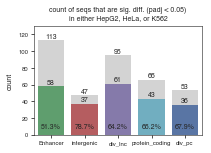

In [40]:
plt.figure(figsize=(3, 2))

ax = sns.countplot(data=sig_results, x="PromType2", color="lightgray", order=TSS_CLASS_ORDER)
sns.countplot(data=sig_results[sig_results["sig_in_any"]], x="PromType2", palette=TSS_CLASS_PALETTE, 
              order=TSS_CLASS_ORDER, ax=ax)

counts = []
tots = []
for i, p in enumerate(ax.patches):
    if i <= 4 :
        tots.append(p.get_height())
    else:
        counts.append(p.get_height())
    text = int(p.get_height())
    ax.annotate(text, (p.get_x() + p.get_width()/2., p.get_height()), 
                ha="center", va="bottom", size=fontsize)

for i in range(len(counts)):
    percent = (float(counts[i])/tots[i])*100
    text = "%.1f%%" % percent
    ax.annotate(text, (i, 5), ha="center", va="bottom", size=fontsize)

plt.xlabel("")
plt.ylim((0, 130))
plt.title("count of seqs that are sig. diff. (padj < 0.05)\nin either HepG2, HeLa, or K562")
plt.savefig("Fig_S9.pdf", bbox_inches="tight", dpi="figure")

## 9. remove tmp files

In [41]:
!rm tmp/*.txt